In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from src.stations import Stations
from src.track import Track, TrackCollection

%matplotlib inline

## Grounds to include station 150 separately

In [3]:
# I carried out several attempts to synchronize stations and found that 
# there are two ways how one can reach stations around station 150:
# - include station 150 initially together with other good stations;
# - add station 150 separately.

# The second approach is preferred as in the roun2_competition dataset
# there is only pair (131, 150) available. One pair is not enough to find
# location of station 150 and also I didn't include station 131 in the best
# 35 good stations.

### How to add station 150:

# Only round2_training1 dataset contains a pair (14, 150), where
# station 14 is a really good station. So, I decided to use default location
# for station 150, just to find its shift using known shift value for station 14.

In [4]:
df = pd.read_csv('data/round2_training1.csv')
tracks = TrackCollection(df)

100%|██████████| 2888/2888 [06:59<00:00,  6.89it/s] 


In [5]:
# Information about sensors

sensors = pd.read_csv('data/round2_sensors.csv')

In [6]:
import json

# Download stations parameters calculated previously
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)

# A0 and B values from optimization of 35 good stations
A0_B = [pow(10, y) for y in [-3.43667365e+00, -4.06472353e+00]]

# New stations object
st = Stations([14, 150])
st.A0 = A0_B[0]
st.B = A0_B[1]

st.update_location(14, st_params['14']['location'])
st.st_params = st_params

st

Stations: 14, 150

## Optimization

In [7]:
from src.solvers import GoodStationsSolver

gss = GoodStationsSolver()
gss.prepare_data(tracks, st, threshold=1500*1e-9, N=10000)

100%|██████████| 2/2 [00:00<00:00, 2215.69it/s]


In [8]:
# Check the number of points available

print(len(gss.points['t1']))

282


In [9]:
# Make optimization
gss.optimize(st, A0_B[0], A0_B[1], [np.log10(st_params['14']['shift'])]*2, optimize_locations_flag=False)

(array([-7.40125063, -7.03697761]), 13.56834792159379)


In [11]:
# Get shift value for station 150
shift_150 = gss.result[0][1] - gss.result[0][0] + np.log10(st_params['14']['shift'])

shift_150 = pow(10, shift_150)
print(shift_150)

1.367967280668568e-07


In [14]:
# Add synchronization
st_params['150'] = {'shift': shift_150,
                    'location': list(sensors.loc[sensors.serial==150, ['latitude', 'longitude', 'height']].values[0])}

st.st_params = st_params

## Save parameters
with open('stations_params.json', 'w') as f:
    json.dump(st_params, f)

Approx Median error [m]: 11.447627912275493


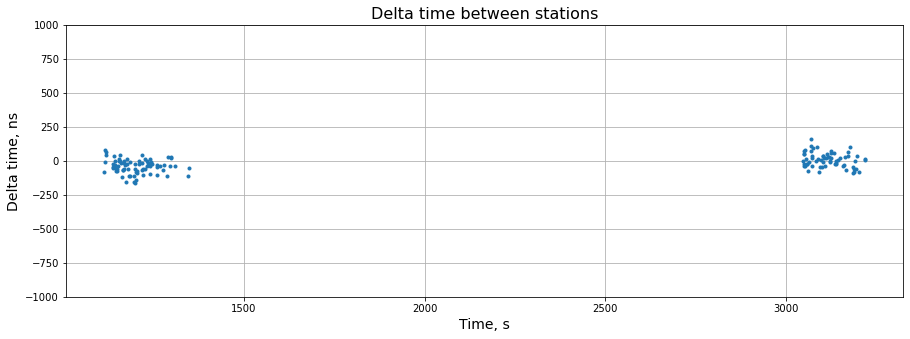

In [15]:
### Check stations synchronization
figsize(15, 5)
_ = tracks.get_aircraft_times(st, (14, 150), verbose=True)